In [2]:
%load_ext autoreload
%autoreload 2

import random
import utils

import pandas as pd

pd.options.display.float_format = '{:.0f}'.format
random.seed(42)

# 1. Load data 

Load data either from downloaded CSV or via REST API.

Data loaded from API is slightly different from the data from CSV, so it needs to be aligned to fit the CSV data.

In [3]:

# basic configurations
READ_FROM_API = False

# load data
if READ_FROM_API:
    CRED_FILE = "credentials.json"
    df_json = utils.read_from_web(CRED_FILE)
    
    web_csv_translation = {
        "timestamp": "Timestamp in local format",
        "player_id": "Name",
        "duration": "Duration (s)",
        "metabolic_power_avg": "Metabolic Power (Ø)",
        "mechanical_load": "Skating Load",
        "mechanical_intensity": "Skating Intensity"
    }
    
    df = df_json.rename(columns=web_csv_translation)
    df["Name"] = df["Name"].apply(lambda x: str(x))
    df["Timestamp (ms)"] = pd.to_datetime(df["Timestamp in local format"]).apply(lambda x: x.timestamp() * 1000)
        
else:
    FILE = "data/Events-Match_Test__TEAM_A_vs__TEAM_B-Period_Period_1_Period_Period_2_Period_Period_3.csv"
    EVENT_TYPE = "Shifts"
    
    # load initial dataset
    df = utils.read_file(FILE, EVENT_TYPE)
    

print("Data Frame loaded successfully!")
df


Data Frame loaded successfully!


,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
0,1670697995000,12/10/2022;07:46:35.000 PM,438,D TEST,Shift,35,114,29,15,25,36,9,0,NaN,337,23,22,37
1,1670697995000,12/10/2022;07:46:35.000 PM,443,D TEST,Shift,44,177,25,21,39,51,36,4,NaN,413,24,29,39
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Guest,Shift,83,288,45,83,70,87,3,0,NaN,0,22,52,38
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Guest,Shift,58,215,34,29,59,79,14,0,NaN,0,22,46,48
11,1670697995000,12/10/2022;07:46:35.000 PM,448,FW TEST,Shift,20,1,1,0,0,0,0,0,NaN,10,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13052,1670705504000,12/10/2022;09:51:44.000 PM,455,FW TEST,Shift,14,30,12,8,0,3,7,0,NaN,357,22,1,4
13085,1670705547000,12/10/2022;09:52:27.000 PM,441,D TEST,Shift,4,1,1,0,0,0,0,0,NaN,63,5,1,22
13086,1670705547000,12/10/2022;09:52:27.000 PM,450,FW TEST,Shift,4,5,5,0,0,0,0,0,NaN,151,8,3,43
13087,1670705547000,12/10/2022;09:52:27.000 PM,453,FW TEST,Shift,4,3,3,0,0,0,0,0,NaN,137,10,2,40


# 2. Experiment with Intensities

Try different configurations ond see how to best calculate the intensities of different shifts.

In [4]:
# Generate dataset

# Remove goalkeepers because they do not belong to s shift
df_no_keepers = df[~df["Name"].str.contains("Goalkeeper")]

if not READ_FROM_API:
    # because we have no actual names when reading from api.
    # but we need to separate teams somehow else. Not done yet.
    df_no_keepers = df_no_keepers[df_no_keepers["Name"].str.contains("Guest")]
    
df_no_keepers

,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Guest,Shift,83,288,45,83,70,87,3,0,NaN,0,22,52,38
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Guest,Shift,58,215,34,29,59,79,14,0,NaN,0,22,46,48
18,1670697995000,12/10/2022;07:46:35.000 PM,478,FW1 Guest,Shift,56,254,24,34,19,37,39,101,NaN,0,28,43,46
19,1670697995000,12/10/2022;07:46:35.000 PM,479,FW2 Guest,Shift,34,109,26,10,21,30,7,15,NaN,0,27,26,45
21,1670697995000,12/10/2022;07:46:35.000 PM,480,FW3 Guest,Shift,33,142,10,8,35,20,40,28,NaN,0,28,21,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12857,1670705329000,12/10/2022;09:48:49.000 PM,468,D1 Guest,Shift,73,80,7,2,12,33,26,0,NaN,0,22,10,8
12881,1670705336000,12/10/2022;09:48:56.000 PM,480,FW3 Guest,Shift,14,26,12,0,0,0,1,13,NaN,0,25,9,37
12912,1670705464000,12/10/2022;09:51:04.000 PM,482,FW5 Guest,Shift,51,118,47,18,18,22,13,0,NaN,0,23,27,31
12913,1670705464000,12/10/2022;09:51:04.000 PM,483,FW6 Guest,Shift,52,200,45,13,33,32,31,42,NaN,0,30,25,29


## 2.1 Intensities for Blocks using elbow-method

Here we see, that there is at least 1 block with too many players.

ELBOW METHOD


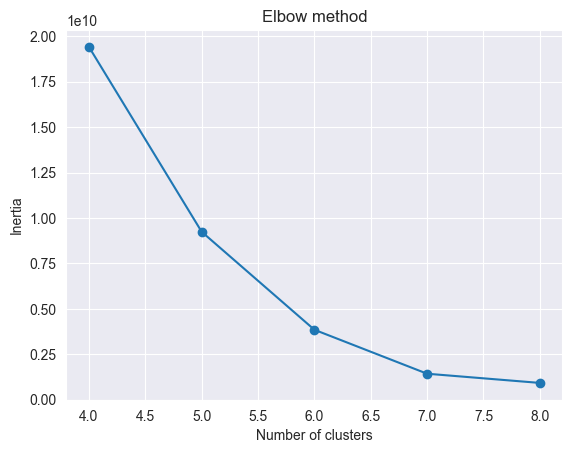

Knee, i.e. calculated number of shifts, is at: 6
Summary of all Shifts. Points are the individual players. Colors are their blocks.


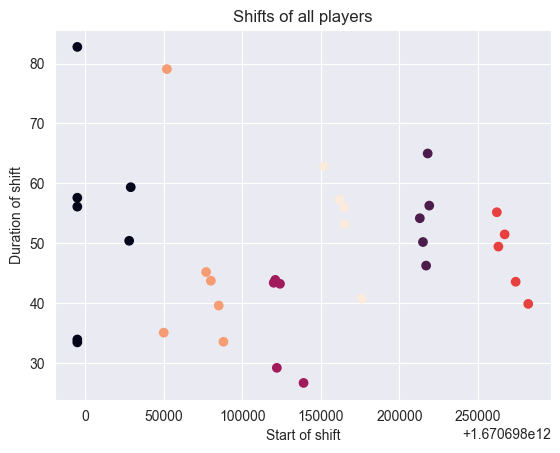

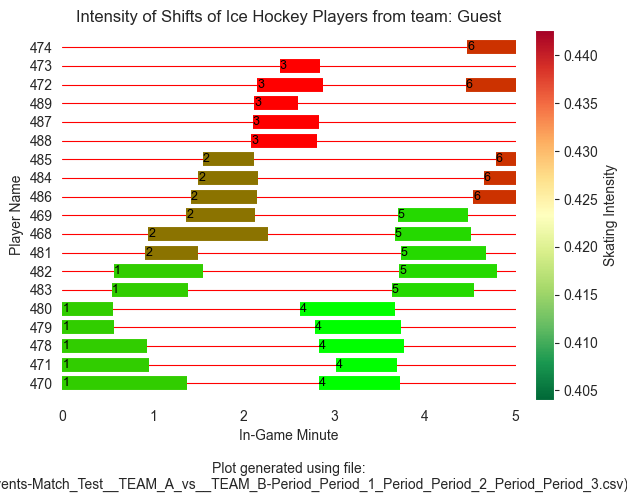

(               timestamp                      time  Timestamp (ms)  \
 4    2022-12-10 18:46:35    0 days 00:01:22.765999   1670697995000   
 7    2022-12-10 18:46:35    0 days 00:00:57.615002   1670697995000   
 18   2022-12-10 18:46:35    0 days 00:00:56.131001   1670697995000   
 19   2022-12-10 18:46:35    0 days 00:00:33.981998   1670697995000   
 21   2022-12-10 18:46:35    0 days 00:00:33.499001   1670697995000   
 155  2022-12-10 18:47:08    0 days 00:00:50.438999   1670698028000   
 159  2022-12-10 18:47:09    0 days 00:00:59.375000   1670698029000   
 242  2022-12-10 18:47:30    0 days 00:00:35.120998   1670698050000   
 250  2022-12-10 18:47:32    0 days 00:01:19.073997   1670698052000   
 370  2022-12-10 18:47:57    0 days 00:00:45.229000   1670698077000   
 383  2022-12-10 18:48:00    0 days 00:00:43.780998   1670698080000   
 401  2022-12-10 18:48:05    0 days 00:00:39.639999   1670698085000   
 416  2022-12-10 18:48:08    0 days 00:00:33.603001   1670698088000   
 569  

In [98]:
block_config = utils.generate_block_config(naive = False,
                                           verbose = True,
                                           team_name = "Guest",
                                           file_name_raw_data = "data/Events-Match_Test__TEAM_A_vs__TEAM_B-Period_Period_1_Period_Period_2_Period_Period_3.csv",)

df_test = utils.plot_shifts_with_intensity(df_no_keepers, block_config=block_config)
df_test

## 2.2 Intensities for Blocks using naive approach

The shifts make sense, even though there is an overlap for player D1 Guest.

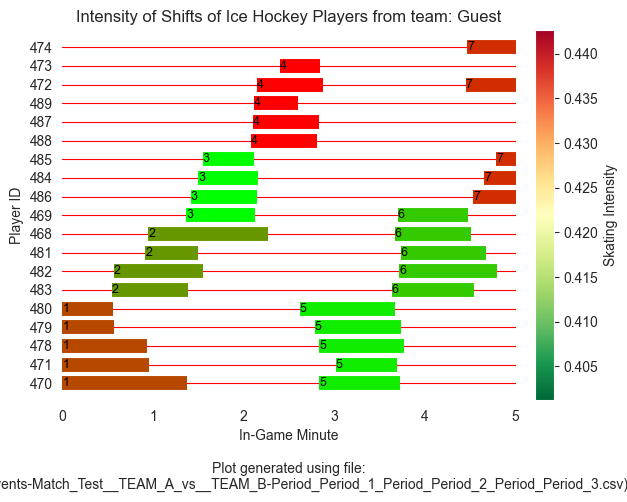

In [101]:
block_config = utils.generate_block_config(naive = True,
                                           verbose = False,
                                           team_name = "Guest",
                                           file_name_raw_data = "data/Events-Match_Test__TEAM_A_vs__TEAM_B-Period_Period_1_Period_Period_2_Period_Period_3.csv",
                                           file_name_save_plot="testi_plot.png")

_ = utils.plot_shifts_with_intensity(df_no_keepers,time_window_start=0, time_window_duration=5, block_config=block_config)
